<a href="https://colab.research.google.com/github/ndb796/PyTorch-Object-Detection/blob/main/Faster_RCNN_with_ResNet_50_on_PASCAL_VOC_2007.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* <b>작성자</b>: 나동빈(dongbinna@postech.ac.kr)
* ResNet-50을 기반으로 하는 Faster RCNN 모델을 PASCAL VOC 2007을 이용해 학습합니다.
* GPU 가속기를 이용하기 위해 <b>[런타임]</b> - <b>[런타임 유형 변경]</b> - <b>[GPU]</b>를 선택합니다.

#### <b>필요한 라이브러리 설치</b>

* <b>mmcv-full</b> 라이브러리를 설치해야 합니다.
* 약 15분가량의 시간이 소요됩니다.

In [1]:
# 종속성 설치(Install Depenencies) (Colab이 CUDA 10.1 기반이므로 cu101 이용)
!pip install -U torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# CUDA 연산을 사용하기 위해 mmcv-full 라이브러리 설치
!pip install mmcv-full

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 704.4MB 26kB/s 
     |████████████████████████████████| 6.6MB 31.9MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101
     |████████████████████████████████| 245kB 5.3MB/s 
     |████████████████████████████████| 194kB 12.9MB/s 
  Created wheel for mmcv-full: filename=mmcv_full-1.2.0-cp36-cp36m-linux_x86_64.whl size=17060076 sha256=9a2d01ffb8824a62e2838286e305127a0146dd25cd7e27ef3eeb4d448790ac4f
  Stored in directory: /root/.cache/pip/wheels/b1/28/b7/e7efc5f0bfd71e6b8da29143406795dccd177fe94eba869cf4
Successfully built mmcv-full


In [2]:
# MMDetection 라이브러리 설치 (Object Detection 목적)
!rm -rf mmdetection
!git clone https://github.com/ndb796/mmdetection # MMDetection에서 VOC 2007 학습 버전을 추가한 저장소
%cd mmdetection

# 필요한 라이브러리 설치
!pip install -e .

# Google Colab에서의 버그를 방지하기 위해 Pillow 7.0.0 구버전을 사용
!pip install Pillow==7.0.0

Cloning into 'mmdetection'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 14297 (delta 8), reused 0 (delta 0), pack-reused 14276
Receiving objects: 100% (14297/14297), 14.14 MiB | 2.18 MiB/s, done.
Resolving deltas: 100% (9718/9718), done.
/content/mmdetection
Obtaining file:///content/mmdetection
  Created wheel for mmpycocotools: filename=mmpycocotools-12.0.3-cp36-cp36m-linux_x86_64.whl size=266785 sha256=fd3802f22b98237f62b0d8fe49cc10dd8c34aa6159ecd9aca09027e0b9b6ee71
  Stored in directory: /root/.cache/pip/wheels/a2/b0/8d/3307912785a42bc80f673946fac676d5c596eee537af7a599c
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=5c49bfdfc45ab0e160d18dafff93cb4f45fb80bdcaa0ef59ce6e6d780a9afc42
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built mmpycocotools termin

#### <b>라이브러리 정상 동작 확인</b>

* 가장 먼저 <b>사전 학습된(Pre-trained)</b> 모델을 다운로드하여 라이브러리 동작을 확인합니다.
* MMDetection이 공식 제공하는 COCO 사전 학습 모델을 사용할 수 있습니다.
* 사용한 모델: Faster RCNN ResNet-50 FPN 1x COCO

In [3]:
!mkdir -p ./checkpoints
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ec5LzmzCAktOnCtu9wV6sEYBL7uO9fL1Kx7fRNv7Iykt0g?download=1 -O ./checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

--2020-11-18 13:58:35--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ec5LzmzCAktOnCtu9wV6sEYBL7uO9fL1Kx7fRNv7Iykt0g?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FYzVMem16Q0FrdE9uQ3R1OXdWNnNFWUJMN3VPOWZMMUt4N2ZSTnY3SXlrdDBnP3J0aW1lPU53UnpDOHFMMkVn [following]
--2020-11-18 13:58:36--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25

* <b>테스트</b>를 위해 한 장의 사진을 준비합니다.

In [4]:
!wget https://image.freepik.com/free-photo/group-portrait-of-adorable-puppies_53876-64796.jpg -O test.jpg

--2020-11-18 13:58:47--  https://image.freepik.com/free-photo/group-portrait-of-adorable-puppies_53876-64796.jpg
Resolving image.freepik.com (image.freepik.com)... 92.123.125.217, 2a02:26f0:e600:2af::30ec, 2a02:26f0:e600:29c::30ec
Connecting to image.freepik.com (image.freepik.com)|92.123.125.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61458 (60K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  60.02K  --.-KB/s    in 0.006s  

2020-11-18 13:58:47 (9.11 MB/s) - ‘test.jpg’ saved [61458/61458]



* <b>모델을 초기화</b>하여 이미지를 테스트합니다.

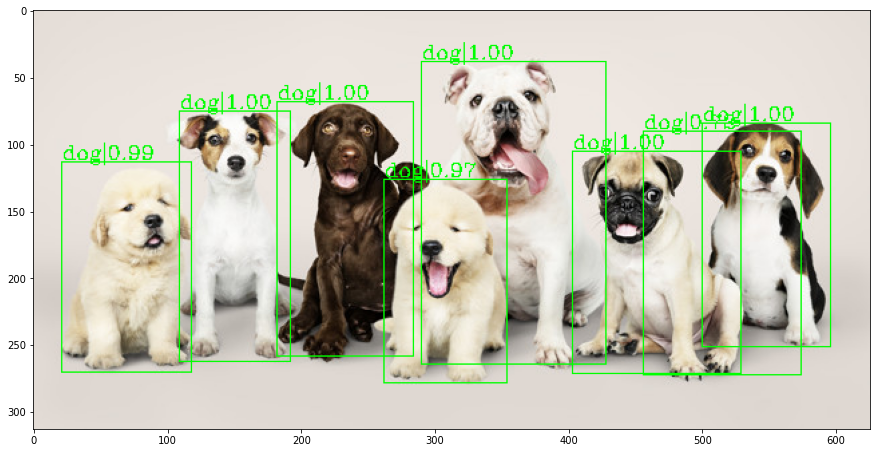

In [5]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv

# 모델 환경 설정 파일과 체크포인트(Checkpoint) 파일 명시
config_file = './configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = './checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth' 

# 환경 설정 파일과 체크포인트 파일을 이용하여 모델 초기화
model = init_detector(config_file, checkpoint_file)

# 단순히 한 장의 이미지를 불러와 테스트
img = 'test.jpg'
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

#### <b>VOC 0712로 학습된 모델을 VOC 2007에서 평가하기</b>

* 가장 먼저 VOC 0712로 <b>사전 학습된(Pre-trained)</b> 모델을 다운로드받습니다.
* 참조된 코드에 따르면 학습은 VOC 2007과 VOC 2012로 진행하되, 평가는 <b>VOC 2007</b>로 진행하고 있습니다.

In [6]:
!mkdir -p ./checkpoints
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EQLKNHIEYChEk6X5lSlWzfMB2k_nQFxmlI1Z78yZHeAJGA?download=1 -O ./checkpoints/faster_rcnn_r50_fpn_1x_voc0712_20200624-c9895d40.pth

--2020-11-18 13:59:16--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EQLKNHIEYChEk6X5lSlWzfMB2k_nQFxmlI1Z78yZHeAJGA?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/faster_rcnn_r50_fpn_1x_voc0712_20200624-c9895d40.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FUUxLTkhJRVlDaEVrNlg1bFNsV3pmTUIya19uUUZ4bWxJMVo3OHlaSGVBSkdBP3J0aW1lPVFQWW5KTXFMMkVn [following]
--2020-11-18 13:59:18--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/faster_rcnn_r50_fpn_1x_voc0712_20200624-c9895d40.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hb

* <b>VOC 2007 데이터셋을 다운로드</b>합니다.

In [7]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EYxPewFjc0dDre-A2xmtNn0B245hklQaByFZuUZDcjeGAQ?download=1 -O VOC2007Train.tar
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Eb_Zsk3K75pPmGXZkgG3-CIBzvCPIMNHZkVYGp2U-ePfXg?download=1 -O VOC2007Test.tar

--2020-11-18 13:59:26--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EYxPewFjc0dDre-A2xmtNn0B245hklQaByFZuUZDcjeGAQ?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/datasets/VOCtrainval_06-Nov-2007.tar?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FWXhQZXdGamMwZERyZS1BMnhtdE5uMEIyNDVoa2xRYUJ5Rlp1VVpEY2plR0FRP3J0aW1lPVl5SXJLc3FMMkVn [following]
--2020-11-18 13:59:28--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/datasets/VOCtrainval_06-Nov-2007.tar?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FWXhQZXdGamM

* <b>데이터셋 압축 파일의 압축을 해제</b>합니다.
* mmdetection의 <b>data 경로에 압축을 해제</b>해야 정상적으로 동작합니다.

In [8]:
!mkdir -p ./data/
!tar -xvf VOC2007Train.tar -C ./data/
!tar -xvf VOC2007Test.tar -C ./data/

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
VOCdevkit/VOC2007/JPEGImages/000725.jpg
VOCdevkit/VOC2007/JPEGImages/000727.jpg
VOCdevkit/VOC2007/JPEGImages/000732.jpg
VOCdevkit/VOC2007/JPEGImages/000734.jpg
VOCdevkit/VOC2007/JPEGImages/000735.jpg
VOCdevkit/VOC2007/JPEGImages/000736.jpg
VOCdevkit/VOC2007/JPEGImages/000737.jpg
VOCdevkit/VOC2007/JPEGImages/000741.jpg
VOCdevkit/VOC2007/JPEGImages/000743.jpg
VOCdevkit/VOC2007/JPEGImages/000744.jpg
VOCdevkit/VOC2007/JPEGImages/000745.jpg
VOCdevkit/VOC2007/JPEGImages/000747.jpg
VOCdevkit/VOC2007/JPEGImages/000749.jpg
VOCdevkit/VOC2007/JPEGImages/000751.jpg
VOCdevkit/VOC2007/JPEGImages/000757.jpg
VOCdevkit/VOC2007/JPEGImages/000758.jpg
VOCdevkit/VOC2007/JPEGImages/000759.jpg
VOCdevkit/VOC2007/JPEGImages/000762.jpg
VOCdevkit/VOC2007/JPEGImages/000765.jpg
VOCdevkit/VOC2007/JPEGImages/000766.jpg
VOCdevkit/VOC2007/JPEGImages/000769.jpg
VOCdevkit/VOC2007/JPEGImages/000773.jpg
VOCdevkit/VOC2007/JPEGImages/000775.jpg
VOCdevkit/VOC2007/JPEGImages/000778.jpg
VOCd

* PASCAL VOC 2007 TEST 데이터셋을 이용해 <b>모델의 성능을 테스트</b>합니다.
* Google Colab 환경에서 5~7분가량의 시간이 소요됩니다.

In [9]:
!python tools/test.py \
    configs/pascal_voc/faster_rcnn_r50_fpn_1x_voc0712.py \
    checkpoints/faster_rcnn_r50_fpn_1x_voc0712_20200624-c9895d40.pth \
    --eval mAP

[>>] 4952/4952, 17.4 task/s, elapsed: 285s, ETA:     0s
+-------------+------+-------+--------+-------+
| class       | gts  | dets  | recall | ap    |
+-------------+------+-------+--------+-------+
| aeroplane   | 285  | 856   | 0.912  | 0.833 |
| bicycle     | 337  | 1076  | 0.932  | 0.856 |
| bird        | 459  | 1083  | 0.898  | 0.792 |
| boat        | 263  | 1273  | 0.871  | 0.689 |
| bottle      | 469  | 1654  | 0.812  | 0.690 |
| bus         | 213  | 714   | 0.958  | 0.851 |
| car         | 1201 | 3408  | 0.957  | 0.878 |
| cat         | 358  | 929   | 0.964  | 0.893 |
| chair       | 756  | 4635  | 0.880  | 0.665 |
| cow         | 244  | 906   | 0.963  | 0.838 |
| diningtable | 206  | 1904  | 0.927  | 0.722 |
| dog         | 489  | 1533  | 0.986  | 0.879 |
| horse       | 348  | 1050  | 0.948  | 0.857 |
| motorbike   | 325  | 1086  | 0.932  | 0.841 |
| person      | 4528 | 12054 | 0.938  | 0.857 |
| pottedplant | 480  | 2530  | 0.819  | 0.550 |
| sheep       | 242  | 715   | 0

#### <b>VOC 2007로 모델을 학습하기</b>

* VOC 2007 데이터셋만을 이용해 학습을 진행합니다.
* 원본 MMDetection에서는 VOC 2007과 VOC 2012을 이용해 학습을 진행하므로, 별도의 설정 파일이 필요합니다.
* 개인 저장소에 이 내용을 기록했습니다.

In [10]:
!python tools/train.py \
    ./configs/pascal_voc/faster_rcnn_r50_fpn_1x_voc07.py

2020-11-18 14:06:55,107 - mmdet - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.6.9 (default, Oct  8 2020, 12:12:24) [GCC 8.4.0]
CUDA available: True
GPU 0: Tesla P100-PCIE-16GB
CUDA_HOME: /usr/local/cuda
NVCC: Cuda compilation tools, release 10.1, V10.1.243
GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
PyTorch: 1.5.1+cu101
PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2019.0.5 Product Build 20190808 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v0.21.1 (Git Hash 7d2fd500bc78936d1d648ca713b901012f470dbc)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 10.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gen

#### <b>VOC 2007로 학습된 모델 평가하기</b>

* VOC 2007 데이터셋만을 이용해 평가를 진행합니다.
* PASCAL VOC 2007 TEST 데이터셋을 이용해 <b>모델의 성능을 테스트</b>합니다.
* 평가를 진행할 때마다 Google Colab 환경에서 5~7분가량의 시간이 소요됩니다.
* Google Colab 환경에서 약 17 FPS를 보입니다.

##### <b>[TEST] IoU Threshold: 0.5 (mAP\@0.5)</b>

* datasets/voc.py에서 iou_thr의 값을 변경하여 테스트를 진행합니다.

In [11]:
!python tools/test.py \
    configs/pascal_voc/faster_rcnn_r50_fpn_1x_voc07.py \
    work_dirs/faster_rcnn_r50_fpn_1x_voc07/latest.pth \
    --eval mAP

[>>] 4952/4952, 17.1 task/s, elapsed: 290s, ETA:     0s
+-------------+------+-------+--------+-------+
| class       | gts  | dets  | recall | ap    |
+-------------+------+-------+--------+-------+
| aeroplane   | 285  | 900   | 0.898  | 0.768 |
| bicycle     | 337  | 980   | 0.914  | 0.816 |
| bird        | 459  | 1132  | 0.813  | 0.704 |
| boat        | 263  | 1545  | 0.829  | 0.575 |
| bottle      | 469  | 1671  | 0.746  | 0.601 |
| bus         | 213  | 1063  | 0.925  | 0.788 |
| car         | 1201 | 2804  | 0.923  | 0.861 |
| cat         | 358  | 1196  | 0.953  | 0.815 |
| chair       | 756  | 3115  | 0.791  | 0.564 |
| cow         | 244  | 961   | 0.926  | 0.741 |
| diningtable | 206  | 1375  | 0.883  | 0.659 |
| dog         | 489  | 2062  | 0.947  | 0.790 |
| horse       | 348  | 1284  | 0.922  | 0.822 |
| motorbike   | 325  | 1096  | 0.905  | 0.786 |
| person      | 4528 | 11375 | 0.915  | 0.835 |
| pottedplant | 480  | 1885  | 0.710  | 0.489 |
| sheep       | 242  | 746   | 0

##### <b>[TEST] IoU Threshold: 0.6 (mAP\@0.6)</b>

In [16]:
!python tools/test.py \
    configs/pascal_voc/faster_rcnn_r50_fpn_1x_voc07.py \
    work_dirs/faster_rcnn_r50_fpn_1x_voc07/latest.pth \
    --eval mAP

[>>] 4952/4952, 17.3 task/s, elapsed: 285s, ETA:     0s
+-------------+------+-------+--------+-------+
| class       | gts  | dets  | recall | ap    |
+-------------+------+-------+--------+-------+
| aeroplane   | 285  | 900   | 0.839  | 0.731 |
| bicycle     | 337  | 980   | 0.861  | 0.749 |
| bird        | 459  | 1132  | 0.771  | 0.635 |
| boat        | 263  | 1545  | 0.734  | 0.479 |
| bottle      | 469  | 1671  | 0.689  | 0.537 |
| bus         | 213  | 1063  | 0.901  | 0.761 |
| car         | 1201 | 2804  | 0.874  | 0.789 |
| cat         | 358  | 1196  | 0.913  | 0.771 |
| chair       | 756  | 3115  | 0.696  | 0.473 |
| cow         | 244  | 961   | 0.873  | 0.664 |
| diningtable | 206  | 1375  | 0.791  | 0.572 |
| dog         | 489  | 2062  | 0.883  | 0.693 |
| horse       | 348  | 1284  | 0.882  | 0.752 |
| motorbike   | 325  | 1096  | 0.862  | 0.730 |
| person      | 4528 | 11375 | 0.848  | 0.744 |
| pottedplant | 480  | 1885  | 0.621  | 0.409 |
| sheep       | 242  | 746   | 0

##### <b>[TEST] IoU Threshold: 0.7 (mAP\@0.7)</b>

In [15]:
!python tools/test.py \
    configs/pascal_voc/faster_rcnn_r50_fpn_1x_voc07.py \
    work_dirs/faster_rcnn_r50_fpn_1x_voc07/latest.pth \
    --eval mAP

[>>] 4952/4952, 17.2 task/s, elapsed: 288s, ETA:     0s
+-------------+------+-------+--------+-------+
| class       | gts  | dets  | recall | ap    |
+-------------+------+-------+--------+-------+
| aeroplane   | 285  | 900   | 0.670  | 0.545 |
| bicycle     | 337  | 980   | 0.754  | 0.638 |
| bird        | 459  | 1132  | 0.636  | 0.521 |
| boat        | 263  | 1545  | 0.551  | 0.345 |
| bottle      | 469  | 1671  | 0.569  | 0.438 |
| bus         | 213  | 1063  | 0.873  | 0.725 |
| car         | 1201 | 2804  | 0.790  | 0.694 |
| cat         | 358  | 1196  | 0.751  | 0.591 |
| chair       | 756  | 3115  | 0.533  | 0.361 |
| cow         | 244  | 961   | 0.734  | 0.506 |
| diningtable | 206  | 1375  | 0.597  | 0.400 |
| dog         | 489  | 2062  | 0.714  | 0.520 |
| horse       | 348  | 1284  | 0.764  | 0.613 |
| motorbike   | 325  | 1096  | 0.723  | 0.612 |
| person      | 4528 | 11375 | 0.702  | 0.600 |
| pottedplant | 480  | 1885  | 0.440  | 0.255 |
| sheep       | 242  | 746   | 0

##### <b>[TEST] IoU Threshold: 0.8 (mAP\@0.8)</b>

In [17]:
!python tools/test.py \
    configs/pascal_voc/faster_rcnn_r50_fpn_1x_voc07.py \
    work_dirs/faster_rcnn_r50_fpn_1x_voc07/latest.pth \
    --eval mAP

[>>] 4952/4952, 17.0 task/s, elapsed: 291s, ETA:     0s
+-------------+------+-------+--------+-------+
| class       | gts  | dets  | recall | ap    |
+-------------+------+-------+--------+-------+
| aeroplane   | 285  | 900   | 0.418  | 0.282 |
| bicycle     | 337  | 980   | 0.466  | 0.378 |
| bird        | 459  | 1132  | 0.375  | 0.240 |
| boat        | 263  | 1545  | 0.331  | 0.190 |
| bottle      | 469  | 1671  | 0.348  | 0.257 |
| bus         | 213  | 1063  | 0.671  | 0.552 |
| car         | 1201 | 2804  | 0.632  | 0.559 |
| cat         | 358  | 1196  | 0.536  | 0.362 |
| chair       | 756  | 3115  | 0.315  | 0.214 |
| cow         | 244  | 961   | 0.512  | 0.309 |
| diningtable | 206  | 1375  | 0.364  | 0.211 |
| dog         | 489  | 2062  | 0.476  | 0.304 |
| horse       | 348  | 1284  | 0.517  | 0.344 |
| motorbike   | 325  | 1096  | 0.495  | 0.359 |
| person      | 4528 | 11375 | 0.458  | 0.349 |
| pottedplant | 480  | 1885  | 0.213  | 0.130 |
| sheep       | 242  | 746   | 0

##### <b>[TEST] IoU Threshold: 0.9 (mAP\@0.9)</b>

In [18]:
!python tools/test.py \
    configs/pascal_voc/faster_rcnn_r50_fpn_1x_voc07.py \
    work_dirs/faster_rcnn_r50_fpn_1x_voc07/latest.pth \
    --eval mAP

[>>] 4952/4952, 17.1 task/s, elapsed: 289s, ETA:     0s
+-------------+------+-------+--------+-------+
| class       | gts  | dets  | recall | ap    |
+-------------+------+-------+--------+-------+
| aeroplane   | 285  | 900   | 0.074  | 0.045 |
| bicycle     | 337  | 980   | 0.154  | 0.096 |
| bird        | 459  | 1132  | 0.092  | 0.091 |
| boat        | 263  | 1545  | 0.084  | 0.091 |
| bottle      | 469  | 1671  | 0.085  | 0.061 |
| bus         | 213  | 1063  | 0.244  | 0.171 |
| car         | 1201 | 2804  | 0.276  | 0.176 |
| cat         | 358  | 1196  | 0.159  | 0.059 |
| chair       | 756  | 3115  | 0.070  | 0.045 |
| cow         | 244  | 961   | 0.156  | 0.108 |
| diningtable | 206  | 1375  | 0.083  | 0.045 |
| dog         | 489  | 2062  | 0.127  | 0.030 |
| horse       | 348  | 1284  | 0.167  | 0.108 |
| motorbike   | 325  | 1096  | 0.132  | 0.062 |
| person      | 4528 | 11375 | 0.131  | 0.052 |
| pottedplant | 480  | 1885  | 0.035  | 0.091 |
| sheep       | 242  | 746   | 0

#### <b>Loss 감소 시각화</b>

* 본 코드는 실질적으로 <b>12번의 Epoch</b>를 가집니다.
* <b>PASCAL VOC 2007</b>의 경우 학습용 데이터가 <b>약 2,500개</b>이므로, 이를 기준으로 loss 값을 계산합니다.

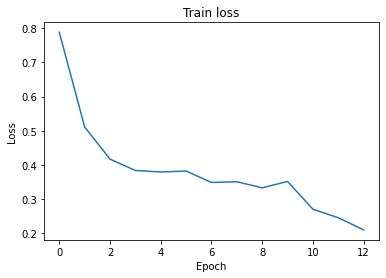

In [24]:
import matplotlib.pyplot as plt

i = [i for i in range(13)]
losses = [0.7885, 0.5112, 0.4171, 0.3839, 0.3795, 0.3822, 0.3488, 0.3509, 0.3331, 0.3518, 0.2705, 0.2455, 0.2099]

plt.plot(i, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train loss')
plt.show()

#### <b>학습 완료된 모델 파일 저장 및 불러와 테스트</b>

In [ ]:
from google.colab import files

files.download('work_dirs/faster_rcnn_r50_fpn_1x_voc07/latest.pth')

In [29]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EQlL8YFVuKVFuk0K_X1RuigBWZO8g9IAuEiHGH-nkZ2PLg?download=1 -O ./faster_rcnn_r50_fpn_1x_voc07_20201119.pth

--2020-11-18 22:09:54--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EQlL8YFVuKVFuk0K_X1RuigBWZO8g9IAuEiHGH-nkZ2PLg?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/faster_rcnn_r50_fpn_1x_voc07_20201119.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FUWxMOFlGVnVLVkZ1azBLX1gxUnVpZ0JXWk84ZzlJQXVFaUhHSC1ua1oyUExnP3J0aW1lPWwteWhyZzZNMkVn [following]
--2020-11-18 22:09:56--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/faster_rcnn_r50_fpn_1x_voc07_20201119.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGV

In [30]:
!python tools/test.py \
    configs/pascal_voc/faster_rcnn_r50_fpn_1x_voc07.py \
    faster_rcnn_r50_fpn_1x_voc07_20201119.pth \
    --eval mAP

[>>] 4952/4952, 17.3 task/s, elapsed: 286s, ETA:     0s
+-------------+------+-------+--------+-------+
| class       | gts  | dets  | recall | ap    |
+-------------+------+-------+--------+-------+
| aeroplane   | 285  | 900   | 0.898  | 0.768 |
| bicycle     | 337  | 980   | 0.914  | 0.816 |
| bird        | 459  | 1132  | 0.813  | 0.704 |
| boat        | 263  | 1545  | 0.829  | 0.575 |
| bottle      | 469  | 1671  | 0.746  | 0.601 |
| bus         | 213  | 1063  | 0.925  | 0.788 |
| car         | 1201 | 2804  | 0.923  | 0.861 |
| cat         | 358  | 1196  | 0.953  | 0.815 |
| chair       | 756  | 3115  | 0.791  | 0.564 |
| cow         | 244  | 961   | 0.926  | 0.741 |
| diningtable | 206  | 1375  | 0.883  | 0.659 |
| dog         | 489  | 2062  | 0.947  | 0.790 |
| horse       | 348  | 1284  | 0.922  | 0.822 |
| motorbike   | 325  | 1096  | 0.905  | 0.786 |
| person      | 4528 | 11375 | 0.915  | 0.835 |
| pottedplant | 480  | 1885  | 0.710  | 0.489 |
| sheep       | 242  | 746   | 0